# fit_baseline_FCN

Fitting arbitrary fully connected neural network (with small-ish number of epochs) to evaluate baseline performance.

--- 
- To evaluate if there are any significant differences between selecting a CNN or a FCN (see fit_baseline_FCN) for the task.
- Playing around with number of layers to check for over-fitting / under-fitting
- Once (relatively) sensible network has been chosen, this will be optimised using keras.tuner in fit_optimised_model

In [1]:
import keras 
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import model_constructors
import evaluate_model

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

### Loading in pre-processed data
- Using binary classifications [i.e. use 0 (don't use) or 1 (use)] due to intrinsic mixing between messy and clean classifications.
- Reshaping X data (i.e adding channel) for CNN input.

In [14]:
# see ../pre-processing/clean_dataset/ for more info
filepath = '/Users/chrisduckworth/projects/ML_portfolio/kin_mis_classification/CNN/pre-processing/clean_dataset_files/'

X_train = np.load(filepath + 'X_train.npy')
X_test = np.load(filepath + 'X_test.npy')
X_val = np.load(filepath + 'X_val.npy')

# adding dimension for CNN input
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
X_val = X_val[..., np.newaxis]

y_train = np.load(filepath + 'y_train_binary.npy')
y_test = np.load(filepath + 'y_test_binary.npy')
y_val = np.load(filepath + 'y_val_binary.npy')

### Plotting class counts
- Computing weights since there is a significant imbalance between the number of 0 and 1s.

/opt/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 1 0 ... 1 1 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


{0: 2.055411535968892, 1: 0.6607291666666667}

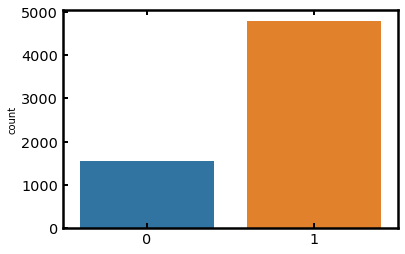

In [3]:
sns.countplot(y_train)

# computing class weights from sklearn and converting to dict (needed for keras input)
weight = class_weight.compute_class_weight('balanced', 
                                           np.unique(y_train),
                                           y_train)

weight = {i : weight[i] for i in np.arange(weight.shape[0])}
weight

In [15]:
train_gen = ImageDataGenerator(rotation_range = 180,  # randomly rotate images in the range (degrees, 0 to 180)
                               horizontal_flip = True, 
                               vertical_flip = True)  # randomly flip images

train_gen.fit(X_train)

### Loading baseline FCN and returning summary.

In [6]:
model = model_constructors.build_fixed_sequential_FCN((32, 32)) 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               131200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

In [16]:
model.fit(train_gen.flow(X_train, y_train, batch_size=32),
          validation_data=(X_val, y_val), 
          class_weight=weight, epochs=50)

Epoch 1/50
199/199 [==============================] - 1s 7ms/step - loss: 0.5072 - accuracy: 0.8114 - val_loss: 0.5120 - val_accuracy: 0.7967
Epoch 2/50
199/199 [==============================] - 1s 6ms/step - loss: 0.4336 - accuracy: 0.8275 - val_loss: 0.4921 - val_accuracy: 0.7669
Epoch 3/50
199/199 [==============================] - 1s 6ms/step - loss: 0.4316 - accuracy: 0.8304 - val_loss: 0.4929 - val_accuracy: 0.8085
Epoch 4/50
199/199 [==============================] - 1s 6ms/step - loss: 0.4248 - accuracy: 0.8340 - val_loss: 0.4632 - val_accuracy: 0.8397
Epoch 5/50
199/199 [==============================] - 1s 7ms/step - loss: 0.4230 - accuracy: 0.8362 - val_loss: 0.4692 - val_accuracy: 0.8463
Epoch 6/50
199/199 [==============================] - 1s 6ms/step - loss: 0.4178 - accuracy: 0.8400 - val_loss: 0.4399 - val_accuracy: 0.8454
Epoch 7/50
199/199 [==============================] - 1s 6ms/step - loss: 0.4201 - accuracy: 0.8412 - val_loss: 0.4842 - val_accuracy: 0.8487
Epoch 

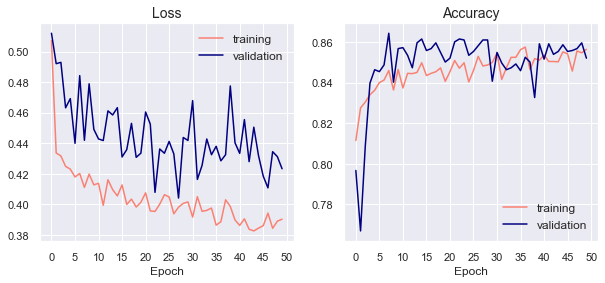

In [17]:
ax = evaluate_model.plot_loss_acc(model.history)

In [18]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
y_predict = model.predict(X_test)
y_predict_binary = (y_predict > 0.5).astype("int32")

67/67 [==============================] - 0s 1ms/step - loss: 0.4140 - accuracy: 0.8723


### Sanity check of predicted classification histogram
- This is basically to check if it has assigned everything to a single class.. 

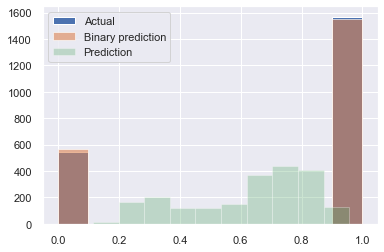

In [19]:
### Sanity check of predicted classification histogram
fig, ax = plt.subplots()
ax.hist(y_test, label='Actual')
ax.hist(y_predict_binary, alpha = 0.6, label='Binary prediction')
ax.hist(y_predict, alpha = 0.3, label='Prediction')
ax.legend()
plt.show()

### Plotting confusion matrix

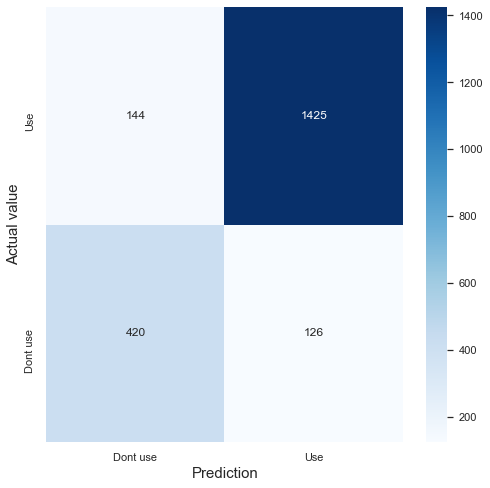

In [20]:
y_predict = model.predict(X_test)
# converting to definite classes.
y_predict_classes = (y_predict > 0.5).astype("int32")

evaluate_model.plot_confusion_matrix(y_test, y_predict_classes, labels=['Dont use', 'Use'])